## Something weird is going on with casting values in dfs

In [1]:
import os
import pandas as pd
import numpy as np
import json

## Loading the data

In [2]:
data_dir = "./data"
json_files = os.listdir(path=data_dir)

In [3]:
companies_list = []
for jf in json_files:
    with open(os.path.join(data_dir, jf)) as jfp:
        companies_list.append(json.load(jfp))

In [4]:
companies_df = pd.DataFrame(companies_list)

In [5]:
companies_df = companies_df.loc[:, ["tags", "hiring_policies"]]

In [6]:
companies_df.head(3)

,tags,hiring_policies
0,"[Node.js, React, TypeScript, GraphQL, Kotlin, ...",[Direct]
1,"[AWS, DevOps, Docker, Django, Firebase, Flutte...",[Direct]
2,"[PHP, Java, GCP, Data Analysis, Data Science]",[Direct]


In [7]:
# fixing nan values
num_of_na_values = companies_df.tags.isna().sum()
companies_df.loc[companies_df.tags.isna(), "tags"] = [["unknown"]]*num_of_na_values

In [8]:
# Some companies have ["-"] as a list of tags
# and some have ["-"] as a list of hiring_policies
dash_tags_df = companies_df.loc[:, ["tags"]].map(lambda tl: tl==["-"])
dash_hp_df = companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"])

In [9]:
len(dash_tags_df.loc[dash_tags_df.tags==True])

5

In [10]:
len(dash_hp_df.loc[dash_hp_df.hiring_policies==True])

37

In [11]:
# Replacing dash tags works fine:
num_of_dash_tags = len(dash_tags_df.loc[dash_tags_df.tags==True])
companies_df.loc[dash_tags_df.tags, "tags"] = [["unknown"]]*num_of_dash_tags

In [12]:
companies_df.loc[dash_tags_df.tags, "tags"]

24     [unknown]
54     [unknown]
167    [unknown]
176    [unknown]
219    [unknown]
Name: tags, dtype: object

In [13]:
# Replacing dash hp assigns "unknown" instead of ["unknown"]
num_of_dash_hp = len(dash_hp_df.loc[dash_hp_df.hiring_policies==True])
companies_df.loc[dash_hp_df.hiring_policies, "hiring_policies"] = [["unknown"]]*num_of_dash_hp

In [14]:
companies_df.hiring_policies

0        [Direct]
1        [Direct]
2        [Direct]
3       [unknown]
4      [Contract]
          ...    
335    [Contract]
336     [unknown]
337     [unknown]
338      [Direct]
339      [Direct]
Name: hiring_policies, Length: 340, dtype: object

How many unique tags do we have at this point?

In [24]:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 461 unique tags.


Now for the styling problems it would be ideal to build a mapping (an hash map, dict or whatever) between different versions of the same tag and a single version that we want to keep in our final dataset.  
461 tags are not that many tags to go through by hands to build our dictionary, but being that we are in 2024 this might just be the perfect job to delegate to an LLM chatbot.  
I fed the full list of unique tags to a famous LLM chatbot and after fiddling a bit with prompts to convince it to give me the desired output and finally came up with a dict that looks like this:

In [25]:
from tags_repl import tags_replacement

In [26]:
for k in list(tags_replacement.keys())[4:11]:
    print(f"{k} -> {tags_replacement[k]}")

AI -> AI/ML
AI/ML -> AI/ML
API Integrations -> API Integrations
AR (Augmented Reality) -> AR (Augmented Reality)
ASP.NET Core -> ASP.NET Core
AWS -> AWS
AWS Cloud -> AWS


It is not completely perfect but most inconsistencies and duplicates are solved. Just a fast test to be sure nothing is missing...

In [27]:
print("Any tags coming from hallucinations?")
for t in tags_replacement.keys():
    if t not in unique_tags:
        print(t)

Any tags coming from hallucinations?


In [28]:
print("Any tags disappeared in the process?")
keys_repl = set(tags_replacement.keys())
for t in unique_tags:
    if t not in keys_repl:
        print(t)

Any tags disappeared in the process?


... and looks like we are good to go.

In [29]:
def replace_tags(tl: list[str]):
    return [tags_replacement[t] for t in tl]

companies_df.tags = companies_df.loc[:, "tags"].map(replace_tags)

There is still a minor annoyance: some tags are "composite" like "JavaScript/TypeScript" or "Node.js/React". In some cases they make sense but other times we want to split them.

In [30]:
tags_to_split = [
    "Java/Maven", "Elixir/Erlang", "JavaScript/TypeScript", "Node.js/React", "C#/.NET"
]
def split_composite_tags(tl: list[str]):
    new_tl = []
    for t in tl:
        if t in tags_to_split:
            new_tl.extend(t.split("/"))
        else:
            new_tl.append(t)
    return new_tl

companies_df.tags = companies_df.tags.map(split_composite_tags)

In [31]:
# update the unique tags list:
unique_tags = set()
for tagslist in companies_df.tags:
    if type(tagslist) == list:
        unique_tags.update(tagslist)
print(f"We have {len(unique_tags)} unique tags.")

We have 366 unique tags.


Let's try to visualize **the most requested technolgies and skills** from companies hiring Italian developers remotely.

In [32]:
tag_counts = {}
for t in unique_tags:
    tag_counts[t] = companies_df.tags.map(lambda tl: t in tl).sum()

In [33]:
tags_counts_df = pd.DataFrame.from_dict(tag_counts, orient="index", columns=["count"])

In [34]:
tags_counts_df.sort_values(by="count", ascending=False, inplace=True)

In [35]:
tags_counts_df.insert(
    loc=len(tags_counts_df.columns),
    column="proportion",
    value=tags_counts_df.loc[:, "count"]/len(companies_df)
)

In [36]:
from wordcloud import WordCloud

(-0.5, 899.5, 899.5, -0.5)

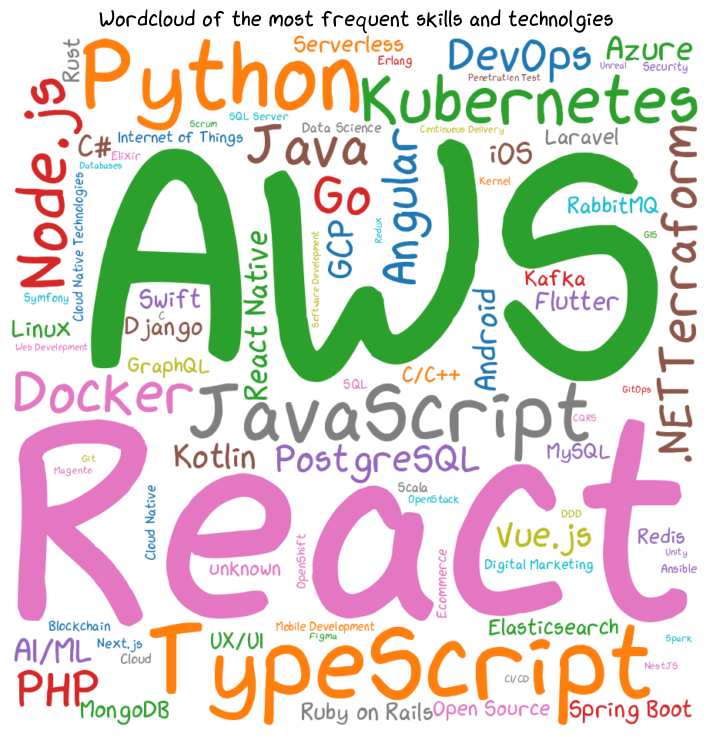

In [37]:
height = 900
width = 900
my_dpi = 96
wc = WordCloud(width=width, height=height, min_font_size=12, background_color="white", colormap="tab10", font_path="xkcd-script.ttf", max_words=500
).generate_from_frequencies(tag_counts)
plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation="bilinear")
plt.title("Wordcloud of the most frequent skills and technolgies")
plt.axis("off")

Text(0.5, 1.0, "Top 25 tech/skills appearing in companies' tags")

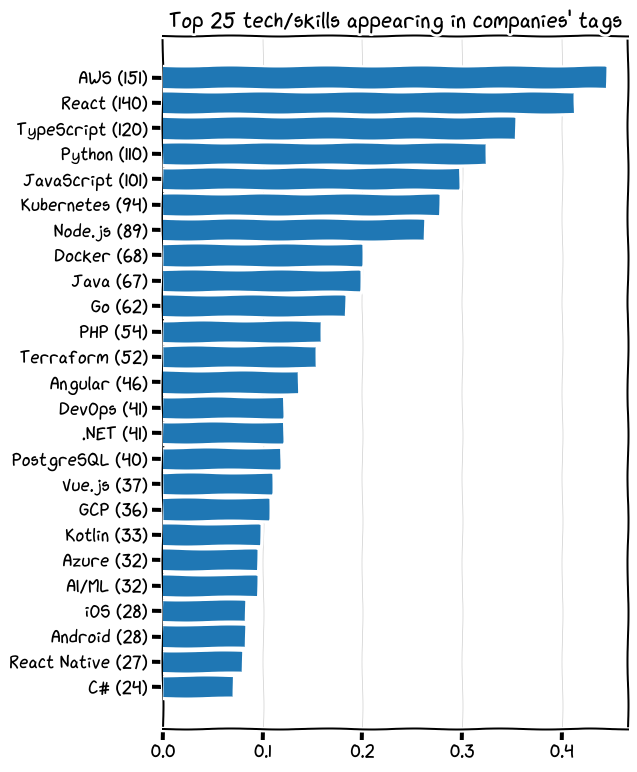

In [38]:
temp_df = tags_counts_df.sort_values(by="proportion").tail(25)
plt.figure(figsize=(600/my_dpi, 900/my_dpi), dpi=my_dpi)
y_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
plt.barh(width=temp_df.loc[:, "proportion"], y=y_labels, zorder=3)
plt.grid(visible=True, axis="x", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Top 25 tech/skills appearing in companies' tags")

The following tags have only 1 occurrence.

In [39]:
tags_with_one_occurrence = list(tags_counts_df.loc[tags_counts_df["count"]==1].index)
tags_with_one_occurrence = sorted(tags_with_one_occurrence)
cols = [[]]
c, tinc = 0, 0
for t in tags_with_one_occurrence:
    if tinc==30:
        cols.append([])
        tinc=0
        c+=1
    cols[c].append(t)
    tinc+=1

# fill the last column to be the same length as the others
for i in range(len(cols[-1]), len(cols[-2])):
    cols[-1].append("")

In [40]:
print(f"The following {len(tags_with_one_occurrence)} tags only appear once:")
for row in zip(*cols):
    print(("{:<28}"*len(cols)).format(*row))

The following 202 tags only appear once:
.NET Core 5                 CPaaS                       ESP32                       IT Managed Services         Multimedia                  REST                        TimeScale                   
3D                          CRM                         EdTech                      Identity                    Nakama                      Rancher                     Tomcat                      
ACSIA                       CSS                         Elastic                     Inclusive content           Native Mobile Development   Remix                       Training                    
API Integrations            Cassandra                   Elm                         Influencer Marketing        NativeScript                SAML                        TrinoDB                     
AR (Augmented Reality)      Clean Architecture          EmberJS                     Information architecture    Navision                    SEM                         Tro

**In which categories do the companies fall?**

In [41]:
all_categories_mentions = []
for cl in companies_df.categories:
    if len(cl)==0:
        all_categories_mentions.append("unknown")
    all_categories_mentions.extend(cl)

In [42]:
len(all_categories_mentions)

412

In [43]:
len(all_categories_mentions)/len(companies_df)

1.2117647058823529

In [44]:
unique_categories = set(all_categories_mentions)

In [45]:
unique_categories

{'cloud_software', 'cybersecurity', 'design_ux', 'hr', 'marketing_writing'}

In [46]:
categories_counts = {}
for c in unique_categories:
    categories_counts[c] = 0
    for cm in all_categories_mentions:
        if cm==c:
            categories_counts[c]+=1

categories_counts_df = pd.DataFrame.from_dict(categories_counts, orient="index", columns=["count"])
categories_counts_df.insert(
    loc=len(categories_counts_df.columns),
    column="proportion",
    value=categories_counts_df.loc[:, "count"]/len(companies_df)
)

In [47]:
categories_counts_df

,count,proportion
cybersecurity,12,0.035294
cloud_software,298,0.876471
hr,12,0.035294
marketing_writing,45,0.132353
design_ux,45,0.132353


Text(0.5, 1.0, 'Distribution of categories among companies')

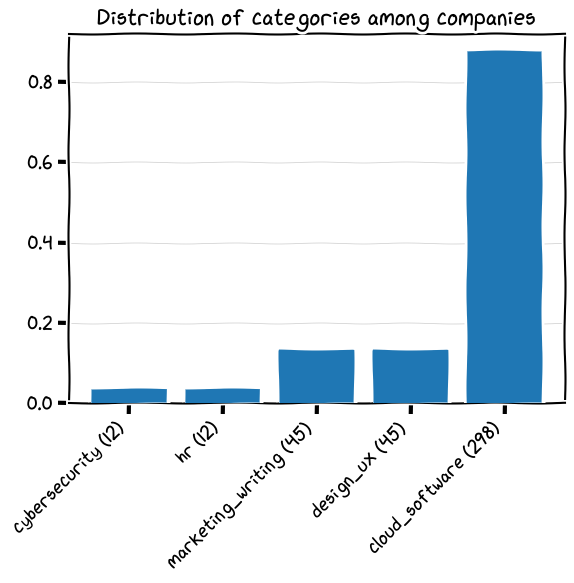

In [48]:
temp_df = categories_counts_df.sort_values(by="proportion")
x_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
fig, ax1 = plt.subplots()
ax1.bar(height=temp_df.loc[:, "proportion"], x=x_labels, zorder=3)
ax1.set_xticks(range(len(temp_df.index)))
ax1.set_xticklabels(x_labels, rotation=45, fontdict={"horizontalalignment": "right"})
ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Distribution of categories among companies")

Might be interesting:  
- Which categories are more often present in companies with more than one category?
- Which tags are more often associated with which categories?

In [49]:
num_of_dash = companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"]).hiring_policies.sum()
[["unknown"]]*num_of_dash

[['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown'],
 ['unknown']]

In [50]:
companies_df.loc[companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"]).hiring_policies, ["hiring_policies"]].shape

(37, 1)

**What is the distribution of hiring policies?**

In [51]:
# replacing ["-"] with ["unknown"]
num_of_dash = companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"]).hiring_policies.sum()
companies_df.loc[companies_df.loc[:, ["hiring_policies"]].map(lambda tl: tl==["-"]).hiring_policies, ["hiring_policies"]] = [["unknown"]]*num_of_dash

In [52]:
companies_df.loc[:, ["hiring_policies"]]

,hiring_policies
0,[Direct]
1,[Direct]
2,[Direct]
3,unknown
4,[Contract]
...,...
335,[Contract]
336,unknown
337,unknown
338,[Direct]


In [143]:
all_hp_mentions = []
for hpl in companies_df.hiring_policies:
    all_hp_mentions.extend(hpl)

In [144]:
len(all_hp_mentions)

580

In [145]:
unique_hp = set(all_hp_mentions)

In [146]:
unique_hp

{'Contract', 'Direct', 'Intermediary', 'k', 'n', 'o', 'u', 'w'}

In [120]:
categories_counts = {}
for c in unique_categories:
    categories_counts[c] = 0
    for cm in all_categories_mentions:
        if cm==c:
            categories_counts[c]+=1

categories_counts_df = pd.DataFrame.from_dict(categories_counts, orient="index", columns=["count"])
categories_counts_df.insert(
    loc=len(categories_counts_df.columns),
    column="proportion",
    value=categories_counts_df.loc[:, "count"]/len(companies_df)
)

In [121]:
categories_counts_df

,count,proportion
cybersecurity,12,0.035294
hr,12,0.035294
marketing_writing,45,0.132353
design_ux,45,0.132353
cloud_software,298,0.876471


Text(0.5, 1.0, 'Distribution of categories among companies')

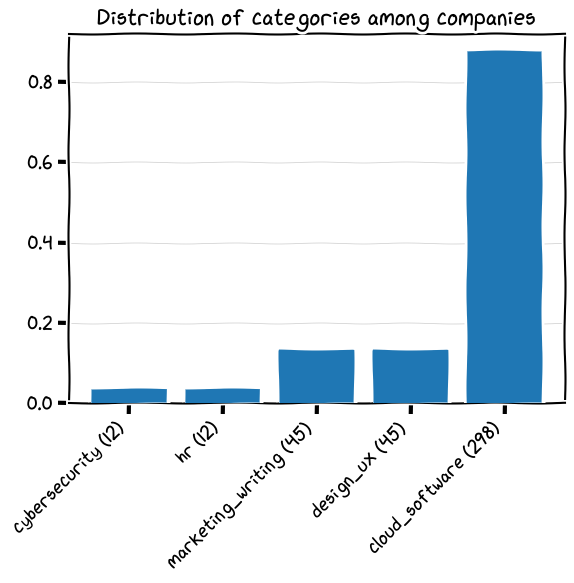

In [132]:
temp_df = categories_counts_df.sort_values(by="proportion")
x_labels = [f"{t} ({c})" for t,c in zip(temp_df.index, temp_df.loc[:, "count"])]
fig, ax1 = plt.subplots()
ax1.bar(height=temp_df.loc[:, "proportion"], x=x_labels, zorder=3)
ax1.set_xticks(range(len(temp_df.index)))
ax1.set_xticklabels(x_labels, rotation=45, fontdict={"horizontalalignment": "right"})
ax1.grid(visible=True, axis="y", color=(0.8,0.8,0.8), zorder=0, lw=0.5)
plt.title("Distribution of categories among companies")

Might be interesting:  
- Which categories are more often present in companies with more than one category?
- Which tags are more often associated with which categories?